In this tutorial, a dynamical decoupling sequence is applied to the electron spin of $^{15}$NV and used to obtain gates to the nuclear spin. We begin defining the NV system, following that we simulate the XY$N$ spectra of the electron observable and compare them with simulations. Finally, we also simulate the behaviour of the nuclear spin. This notebook closely follows the work from:

- L. Tsunaki, M. Dotan, K. Volkova, & B. Naydenov. (2025). Multi-Qubit Gates by Dynamical Decoupling Implemented with IBMQ and 15NV Center in Diamond.

As this is a quite complex problem, physics discussions will be kept to a minimum here in favor of a focus to the simulation. For a detailed explanation of the problem, please refer to the original paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
from qutip import qeye, jmat, tensor, fock_dm

from quaccatoo import NV, XY, ExpData

# 1. Definition of the NV System

We begin defining the NV system and the experimental conditions for the XY$N$ pulse sequences.

In [2]:
system = NV(
    B0 = 32,
    theta = 2.9,
    units_angles = 'deg',
    units_B0 = 'mT',
    N=15
)

# experimental value of pi-pulse duration
t_pi = 0.025694/2
w1 = 1/t_pi/2

# number of pulses
N = np.arange(2, 30, 2)

# free evolution times
tau = np.arange(0.260, .260 + 50*0.004, 0.004)

# 2. Electron Spin

Now the simulations can be run in a loop over the N values and saved into a results array.

In [ ]:
XYN_S_sim = np.empty(N.size, dtype=XY)

for idx in range(N.size):

    # defines the simulation object with the parameters
    XYN_S_sim[idx] = XY(
        free_duration = tau,
        pi_pulse_duration = t_pi,
        system = system,
        h1 = w1*system.MW_h1,
        pulse_params = {'f_pulse': system.MW_freqs[0]},
        M = int(N[idx]/2),
    )

    # runs the simulation and stores the results
    XYN_S_sim[idx].run()

To compare these simulations with the experimental data, we load them with the ExpData class, convert the units of the pulse separation to us and subtract the columns 1 and 2 with the `subtract_results_columns` method to obtain the fluorescence as simulated. The experimental data was obtained and saved within Qudi software's format.

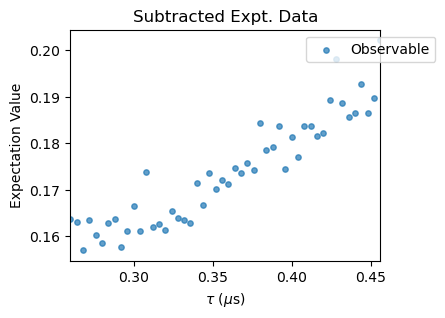

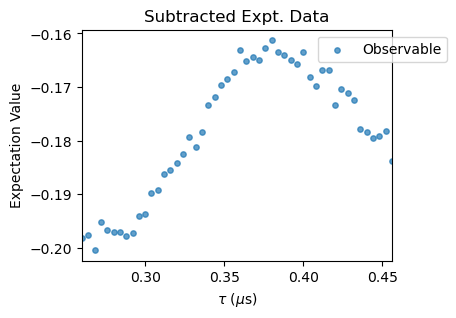

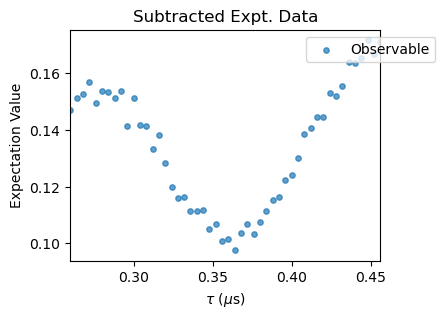

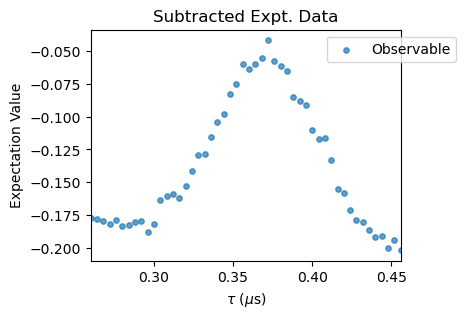

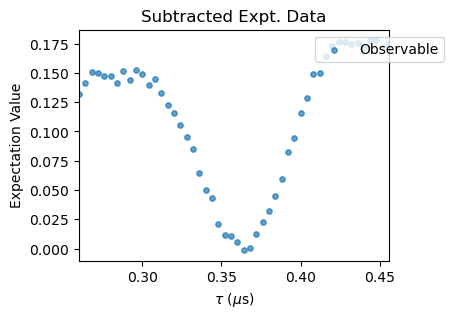

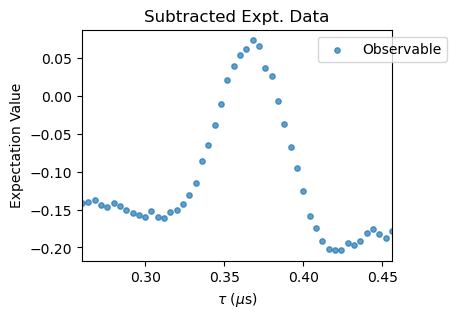

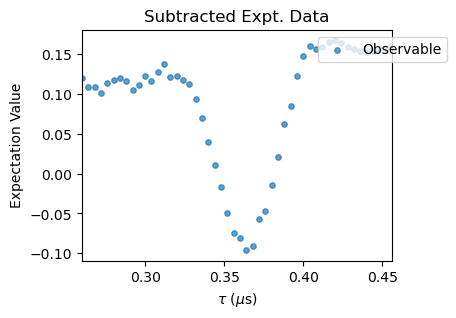

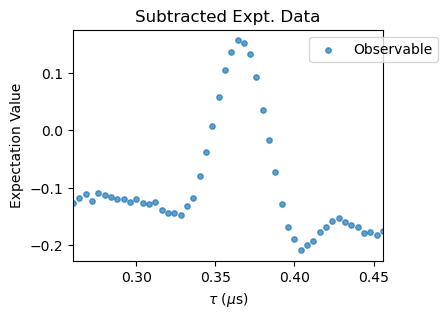

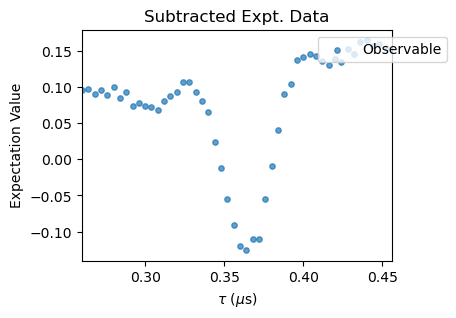

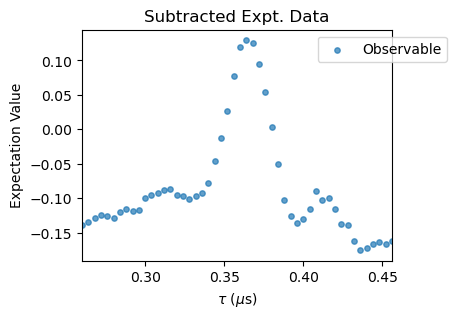

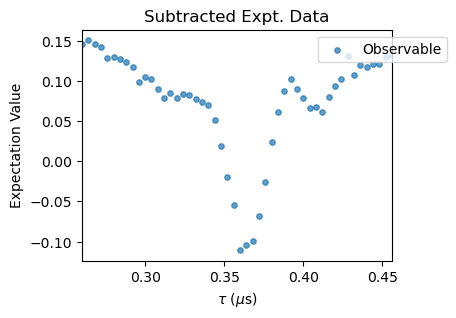

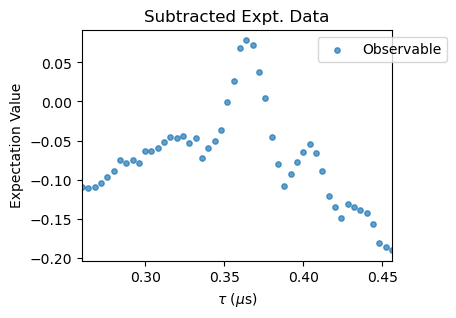

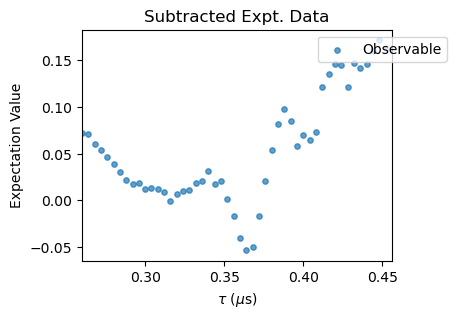

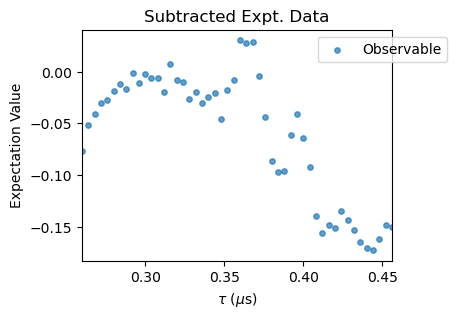

In [5]:
XYN_exp = np.empty(N.size, dtype=ExpData)

for idx in range(N.size):
    XYN_exp[idx] = ExpData(f'./exp_data_tutorials/08/XY{N[idx]}.dat', results_columns=[1,2], variable_name=r'$\tau$ ($\mu$s)')

    # converts the time units to us
    XYN_exp[idx].variable *= 1e6

    XYN_exp[idx].subtract_results_columns(plot=True, figsize=(4,3))

Notice that for large $N$ pulse errors start to affect the spectra. To correct that, a polynomial baseline corrections needs to be performed with the `poly_base_correction` method. In succesion, a rescale and offset corrections are applied to the experimental data through the methods `rescale_correction` and `offset_correction`.

In [7]:
XYN_exp[10].poly_base_correction(x_start=[0, 32, 42], x_end=[10, 34, -1], poly_order=2)
XYN_exp[11].poly_base_correction(x_start=[0, 31, 39, 47], x_end=[9, 33, 41, -1], poly_order=2)
XYN_exp[12].poly_base_correction(x_start=[0, 31, 38, 46], x_end=[20, 33, 41, -1], poly_order=3)
XYN_exp[13].poly_base_correction(x_start=[0, 30, 38, 45], x_end=[12, 32, 40, 46], poly_order=3)

for idx in range(N.size):
    linear_fit = linregress(XYN_exp[idx].results, XYN_S_sim[idx].results)

    XYN_exp[idx].rescale_correction(linear_fit.slope)
    XYN_exp[idx].offset_correction(-linear_fit.intercept)

Finally, we plot the comparison between the simulation and experimental data, from which we observe a strong correlation between both.

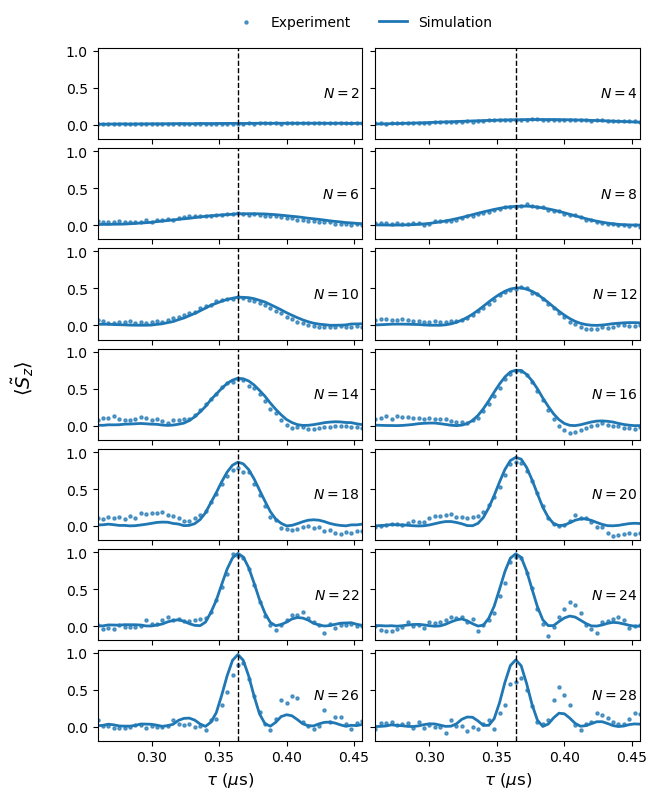

In [14]:
fig, axs = plt.subplots(int(N.size/2), 2, figsize=(7, 9), sharex=True, sharey=True)

for idx in range(int(N.size/2)):

    axs[idx, 0].scatter(tau, 1-XYN_exp[2*idx].results, c='C0', s=5, alpha=.7, label='Experiment')
    axs[idx, 1].scatter(tau, XYN_exp[2*idx+1].results, c='C0', s=5, alpha=.7) 

    axs[idx, 0].plot(tau, 1-XYN_S_sim[2*idx].results, c='C0', lw=2, label='Simulation')
    axs[idx, 1].plot(tau, XYN_S_sim[2*idx+1].results, c='C0', lw=2)

    axs[idx, 0].axvline(tau[26], c='k', lw=1, ls='--')
    axs[idx, 1].axvline(tau[26], c='k', lw=1, ls='--')
    axs[idx, 0].set_xlim(tau[0], tau[-1])

    axs[idx, 0].text(.99, 0.5, f'$N = {N[2*idx]}$', ha='right', va='center', transform=axs[idx, 0].transAxes)
    axs[idx, 1].text(.99, 0.5, f'$N = {N[2*idx+1]}$', ha='right', va='center', transform=axs[idx, 1].transAxes)

fig.text(0, .5, r'$ \langle \tilde{S}_z \rangle $', fontsize=14, rotation=90)
axs[-1, 0].set_xlabel(r'$ \tau $ ($\mu$s)', fontsize=12)
axs[-1, 1].set_xlabel(r'$ \tau $ ($\mu$s)', fontsize=12)
axs[0, 0].legend(frameon=False, loc='upper center', ncols=2, bbox_to_anchor=(1, 1.5))

fig.subplots_adjust(hspace=0.1, wspace=0.05)

# 3. Nuclear Spin

The simulation of nuclear spin follows a similar structure as the electron spin, except that now the observable and initial state need to be redefined.

In [9]:
system.observable = tensor(qeye(3), jmat(1/2,'z'))
system.rho0 = tensor(fock_dm(3, 1), fock_dm(2,0))

XYN_I_sim = np.empty(N.size, dtype=XY)

for idx in range(N.size):

    # defines the simulation object with the parameters
    XYN_I_sim[idx] = XY(
        free_duration = tau,
        pi_pulse_duration = t_pi,
        system = system,
        h1 = w1*system.MW_h1,
        pulse_params = {'f_pulse': system.MW_freqs[0]},
        M = int(N[idx]/2),
    )

    # runs the simulation and stores the results
    XYN_I_sim[idx].run()

Lastly, we compare the nuclear spin simulations with the electron spin. Where the nuclear spin has a time evolution opposite to the electron, which can be use to form the multi-qubit gates as discussed in the paper.

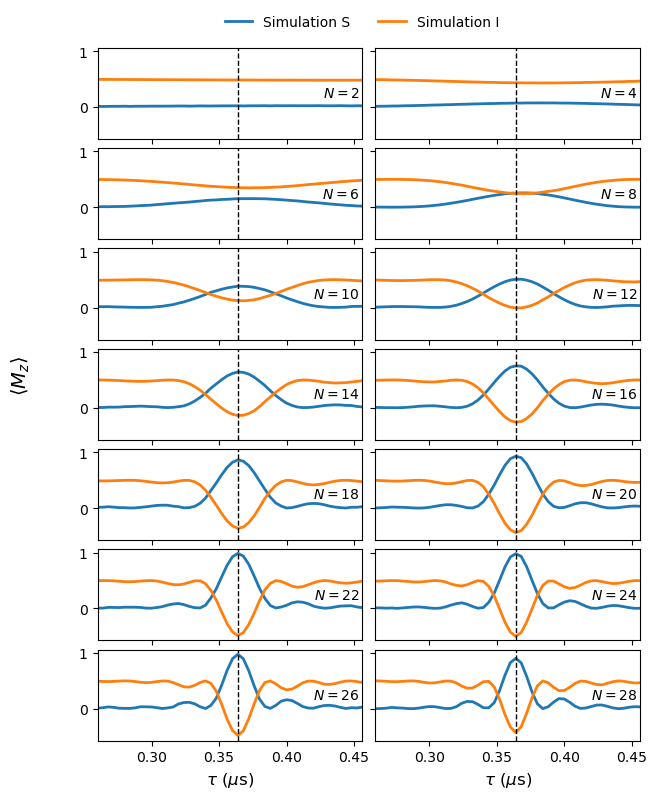

In [16]:
fig, axs = plt.subplots(int(N.size/2), 2, figsize=(7, 9), sharex=True, sharey=True)

for idx in range(int(N.size/2)):

    axs[idx, 0].plot(tau, 1-XYN_S_sim[2*idx].results, lw=2, label='Simulation S')
    axs[idx, 1].plot(tau, XYN_S_sim[2*idx+1].results,lw=2)

    axs[idx, 0].plot(tau, XYN_I_sim[2*idx].results, lw=2, label='Simulation I')
    axs[idx, 1].plot(tau, XYN_I_sim[2*idx+1].results, lw=2)

    axs[idx, 0].axvline(tau[26], c='k', lw=1, ls='--')
    axs[idx, 1].axvline(tau[26], c='k', lw=1, ls='--')
    axs[idx, 0].set_xlim(tau[0], tau[-1])

    axs[idx, 0].text(.99, 0.5, f'$N = {N[2*idx]}$', ha='right', va='center', transform=axs[idx, 0].transAxes)
    axs[idx, 1].text(.99, 0.5, f'$N = {N[2*idx+1]}$', ha='right', va='center', transform=axs[idx, 1].transAxes)

fig.text(0, .5, r'$ \langle M_z \rangle $', fontsize=14, rotation=90)
axs[-1, 0].set_xlabel(r'$ \tau $ ($\mu$s)', fontsize=12)
axs[-1, 1].set_xlabel(r'$ \tau $ ($\mu$s)', fontsize=12)
axs[0, 0].legend(frameon=False, loc='upper center', ncols=2, bbox_to_anchor=(1, 1.5))

fig.subplots_adjust(hspace=0.1, wspace=0.05)